In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

           0
0   2.331587
1   2.881072
2   0.895136
3   1.439184
4   2.340928
..       ...
95  3.097667
96  2.066740
97  2.122958
98  2.888477
99  0.489727

[100 rows x 1 columns]


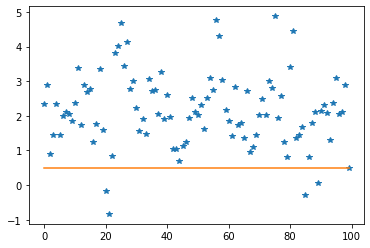

In [35]:
np.random.seed(10)
# Generac0ión de datos.
n = 100
phi = 0.5
c = 1
sigmaSqr = 1
eps = np.random.normal(0, sigmaSqr, n)
Y = np.empty(n)
Y[0] = c + eps[0]
for i in range(1, n):
    Y[i] = c + eps[i] + phi * Y[i - 1]
df = pd.DataFrame(Y)
print(df)
plt.plot(df, '*')
plt.plot(np.ones(n) * (0.5))
plt.show()